In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,GRU

In [4]:
df = pd.read_csv('./data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.drop(['new_confirmed_cases', 'new_deaths'], axis=1)
df.head()

,NO2,CO,PM25,OZONE,PM10,NO,7_day_avg_new_cases,7_day_avg_new_deaths
Date,,,,,,,,
2020-01-26,0.020,0.493,47.3,0.040,50.5,0.005,0.0,0.0
2020-01-27,0.042,0.822,24.6,0.041,40.8,0.071,0.0,0.0
2020-01-28,0.042,0.737,14.9,0.042,27.8,0.083,0.0,0.0
2020-01-29,0.031,0.732,11.0,0.042,44.7,0.037,0.0,0.0
2020-01-30,0.043,1.046,16.2,0.038,42.0,0.094,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267 entries, 2020-01-26 to 2020-10-18
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO2                   267 non-null    float64
 1   CO                    267 non-null    float64
 2   PM25                  267 non-null    float64
 3   OZONE                 267 non-null    float64
 4   PM10                  267 non-null    float64
 5   NO                    267 non-null    float64
 6   7_day_avg_new_cases   267 non-null    float64
 7   7_day_avg_new_deaths  267 non-null    float64
dtypes: float64(8)
memory usage: 18.8 KB


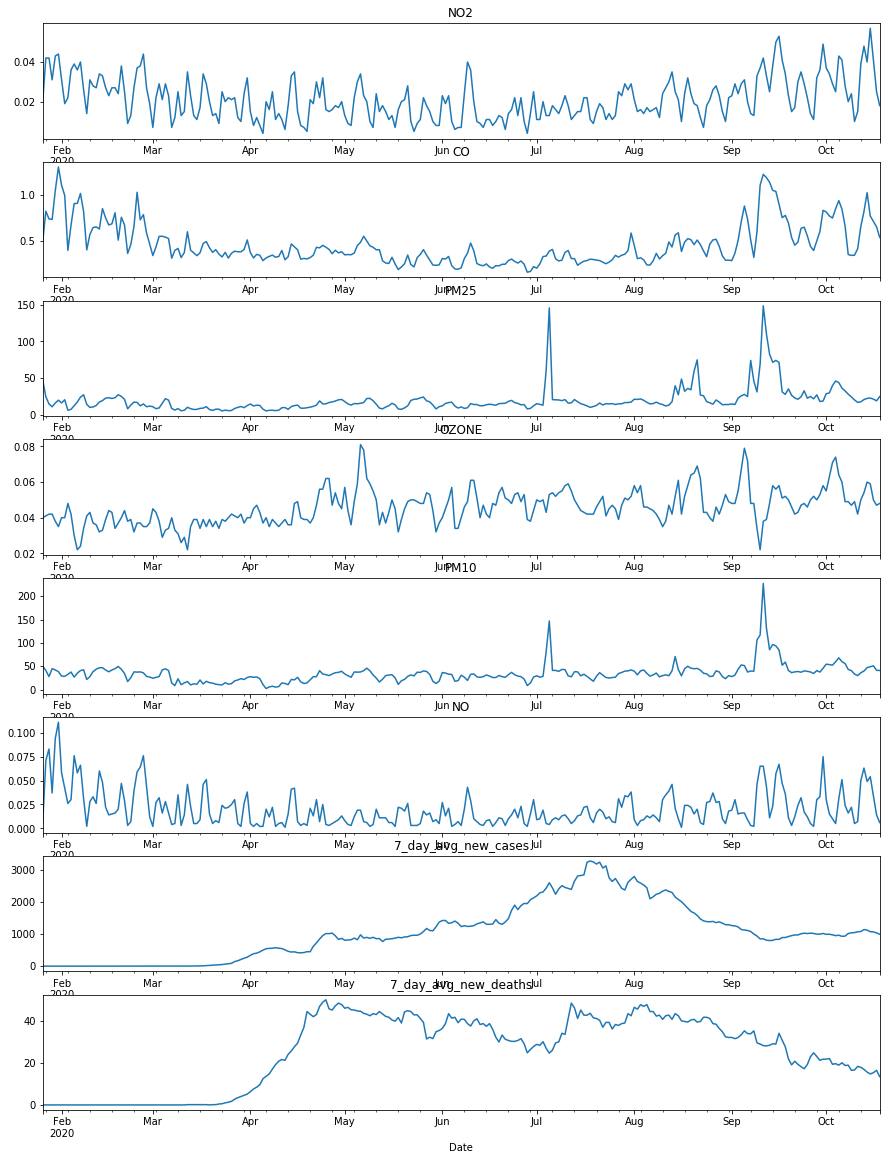

In [6]:
fig,ax = plt.subplots(8,1,figsize=(15,20))
for i,column in enumerate([col for col in df.columns]):
    df[column].plot(ax=ax[i])
    ax[i].set_title(column)

In [172]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def training(trainX, trainY, testX, testY):
    stop_noimprovement = EarlyStopping(patience=20)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), dropout=0.2))
    model.add(Dense(2))
    model.compile(loss="mse",optimizer="adam")
    history = model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)
    return history, model

def prediction(model, testX, testY):
    predicted = model.predict(testX)
    testXRe = testX.reshape(testX.shape[0],testX.shape[2])
    predicted = np.concatenate((testXRe[:,:-2], predicted),axis=1)
    predicted = scaler.inverse_transform(predicted[:,-8:])
    forecast_df = pd.DataFrame(predicted, columns=df.columns)
    forecast_df = forecast_df[['7_day_avg_new_cases', '7_day_avg_new_deaths']]
    new_cases_rmse = np.sqrt(mean_squared_error(testY[:,-2],predicted[:,-2]))
    new_deaths_rmse = np.sqrt(mean_squared_error(testY[:,-1],predicted[:,-1]))
    return new_cases_rmse, new_deaths_rmse
    
def plots(histories):
    
    fig = plt.figure(figsize=(10,40))
    for ((history, _), i) in zip(histories, range(1,len(histories) + 1)):
        plt.tight_layout()
        plt.subplot(len(histories),2,i)
        plt.title(f'Training for {i} input days')
        plt.plot(history.history['loss'],label='train')
        plt.plot(history.history['val_loss'],label='test')
        plt.legend()
    plt.show()

In [134]:
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [135]:
n_train = int(len(df)*.8)

histories = []
predictions = []

for i in range(1,15):
    print(f'***** Training for {i} input days *****')
    reframed = series_to_supervised(scaled,i,1)
    reframed.drop(reframed.columns[[-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)
    values = reframed.values
    train = values[:n_train]
    test = values[n_train:]
    trainX,trainY = train[:,:-2],train[:,-2:]
    testX,testY = test[:,:-2],test[:,-2:]
    trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
    testX = testX.reshape(testX.shape[0],1,testX.shape[1])
    
    history, model = training(trainX, trainY, testX, testY)
    histories.append((history, model))
    
    cases_rmse, deaths_rmse = prediction(model, testX, testY)
    predictions.append((cases_rmse, deaths_rmse))

Train on 213 samples, validate on 53 samples
Epoch 1/100
213/213 - 2s - loss: 0.2992 - val_loss: 0.1688
Epoch 2/100
213/213 - 0s - loss: 0.2771 - val_loss: 0.1469
Epoch 3/100
213/213 - 0s - loss: 0.2545 - val_loss: 0.1267
Epoch 4/100
213/213 - 0s - loss: 0.2332 - val_loss: 0.1075
Epoch 5/100
213/213 - 0s - loss: 0.2124 - val_loss: 0.0895
Epoch 6/100
213/213 - 0s - loss: 0.1939 - val_loss: 0.0724
Epoch 7/100
213/213 - 0s - loss: 0.1729 - val_loss: 0.0569
Epoch 8/100
213/213 - 0s - loss: 0.1537 - val_loss: 0.0431
Epoch 9/100
213/213 - 0s - loss: 0.1379 - val_loss: 0.0316
Epoch 10/100
213/213 - 0s - loss: 0.1173 - val_loss: 0.0228
Epoch 11/100
213/213 - 0s - loss: 0.1077 - val_loss: 0.0169
Epoch 12/100
213/213 - 0s - loss: 0.0989 - val_loss: 0.0142
Epoch 13/100
213/213 - 0s - loss: 0.0867 - val_loss: 0.0141
Epoch 14/100
213/213 - 0s - loss: 0.0762 - val_loss: 0.0159
Epoch 15/100
213/213 - 0s - loss: 0.0716 - val_loss: 0.0188
Epoch 16/100
213/213 - 0s - loss: 0.0648 - val_loss: 0.0218
Epoc

Epoch 50/100
213/213 - 0s - loss: 0.0208 - val_loss: 0.0129
Epoch 51/100
213/213 - 0s - loss: 0.0242 - val_loss: 0.0142
Epoch 52/100
213/213 - 0s - loss: 0.0214 - val_loss: 0.0132
Epoch 53/100
213/213 - 0s - loss: 0.0257 - val_loss: 0.0124
Epoch 54/100
213/213 - 0s - loss: 0.0248 - val_loss: 0.0134
Epoch 55/100
213/213 - 0s - loss: 0.0264 - val_loss: 0.0142
Epoch 56/100
213/213 - 0s - loss: 0.0219 - val_loss: 0.0148
Epoch 57/100
213/213 - 0s - loss: 0.0218 - val_loss: 0.0146
Epoch 58/100
213/213 - 0s - loss: 0.0205 - val_loss: 0.0135
Epoch 59/100
213/213 - 0s - loss: 0.0234 - val_loss: 0.0128
Epoch 60/100
213/213 - 0s - loss: 0.0217 - val_loss: 0.0123
Epoch 61/100
213/213 - 0s - loss: 0.0206 - val_loss: 0.0122
Epoch 62/100
213/213 - 0s - loss: 0.0203 - val_loss: 0.0120
Epoch 63/100
213/213 - 0s - loss: 0.0236 - val_loss: 0.0121
Epoch 64/100
213/213 - 0s - loss: 0.0211 - val_loss: 0.0134
Epoch 65/100
213/213 - 0s - loss: 0.0213 - val_loss: 0.0137
Epoch 66/100
213/213 - 0s - loss: 0.0218

Epoch 25/100
213/213 - 0s - loss: 0.0165 - val_loss: 0.0117
Epoch 26/100
213/213 - 0s - loss: 0.0166 - val_loss: 0.0111
Epoch 27/100
213/213 - 0s - loss: 0.0171 - val_loss: 0.0108
Epoch 28/100
213/213 - 0s - loss: 0.0168 - val_loss: 0.0104
Epoch 29/100
213/213 - 0s - loss: 0.0169 - val_loss: 0.0118
Epoch 30/100
213/213 - 0s - loss: 0.0153 - val_loss: 0.0131
Epoch 31/100
213/213 - 0s - loss: 0.0141 - val_loss: 0.0126
Epoch 32/100
213/213 - 0s - loss: 0.0167 - val_loss: 0.0114
Epoch 33/100
213/213 - 0s - loss: 0.0138 - val_loss: 0.0109
Epoch 34/100
213/213 - 0s - loss: 0.0159 - val_loss: 0.0113
Epoch 35/100
213/213 - 0s - loss: 0.0135 - val_loss: 0.0130
Epoch 36/100
213/213 - 0s - loss: 0.0142 - val_loss: 0.0123
Epoch 37/100
213/213 - 0s - loss: 0.0136 - val_loss: 0.0136
Epoch 38/100
213/213 - 0s - loss: 0.0122 - val_loss: 0.0135
Epoch 39/100
213/213 - 0s - loss: 0.0137 - val_loss: 0.0109
Epoch 40/100
213/213 - 0s - loss: 0.0130 - val_loss: 0.0104
Epoch 41/100
213/213 - 0s - loss: 0.0146

213/213 - 0s - loss: 0.0468 - val_loss: 0.1563
Epoch 6/100
213/213 - 0s - loss: 0.0416 - val_loss: 0.1113
Epoch 7/100
213/213 - 0s - loss: 0.0335 - val_loss: 0.0546
Epoch 8/100
213/213 - 0s - loss: 0.0291 - val_loss: 0.0290
Epoch 9/100
213/213 - 0s - loss: 0.0255 - val_loss: 0.0229
Epoch 10/100
213/213 - 0s - loss: 0.0203 - val_loss: 0.0219
Epoch 11/100
213/213 - 0s - loss: 0.0213 - val_loss: 0.0206
Epoch 12/100
213/213 - 0s - loss: 0.0196 - val_loss: 0.0173
Epoch 13/100
213/213 - 0s - loss: 0.0187 - val_loss: 0.0154
Epoch 14/100
213/213 - 0s - loss: 0.0176 - val_loss: 0.0168
Epoch 15/100
213/213 - 0s - loss: 0.0183 - val_loss: 0.0186
Epoch 16/100
213/213 - 0s - loss: 0.0145 - val_loss: 0.0169
Epoch 17/100
213/213 - 0s - loss: 0.0149 - val_loss: 0.0154
Epoch 18/100
213/213 - 0s - loss: 0.0167 - val_loss: 0.0161
Epoch 19/100
213/213 - 0s - loss: 0.0136 - val_loss: 0.0182
Epoch 20/100
213/213 - 0s - loss: 0.0153 - val_loss: 0.0190
Epoch 21/100
213/213 - 0s - loss: 0.0147 - val_loss: 0.01

213/213 - 0s - loss: 0.0099 - val_loss: 0.0133
Epoch 45/100
213/213 - 0s - loss: 0.0108 - val_loss: 0.0122
Epoch 46/100
213/213 - 0s - loss: 0.0103 - val_loss: 0.0121
Epoch 47/100
213/213 - 0s - loss: 0.0105 - val_loss: 0.0156
Train on 213 samples, validate on 41 samples
Epoch 1/100
213/213 - 2s - loss: 0.2726 - val_loss: 0.0557
Epoch 2/100
213/213 - 0s - loss: 0.1418 - val_loss: 0.0073
Epoch 3/100
213/213 - 0s - loss: 0.0641 - val_loss: 0.0806
Epoch 4/100
213/213 - 0s - loss: 0.0451 - val_loss: 0.1454
Epoch 5/100
213/213 - 0s - loss: 0.0379 - val_loss: 0.1062
Epoch 6/100
213/213 - 0s - loss: 0.0323 - val_loss: 0.0552
Epoch 7/100
213/213 - 0s - loss: 0.0274 - val_loss: 0.0325
Epoch 8/100
213/213 - 0s - loss: 0.0239 - val_loss: 0.0317
Epoch 9/100
213/213 - 0s - loss: 0.0195 - val_loss: 0.0300
Epoch 10/100
213/213 - 0s - loss: 0.0165 - val_loss: 0.0241
Epoch 11/100
213/213 - 0s - loss: 0.0163 - val_loss: 0.0222
Epoch 12/100
213/213 - 0s - loss: 0.0164 - val_loss: 0.0255
Epoch 13/100
213/

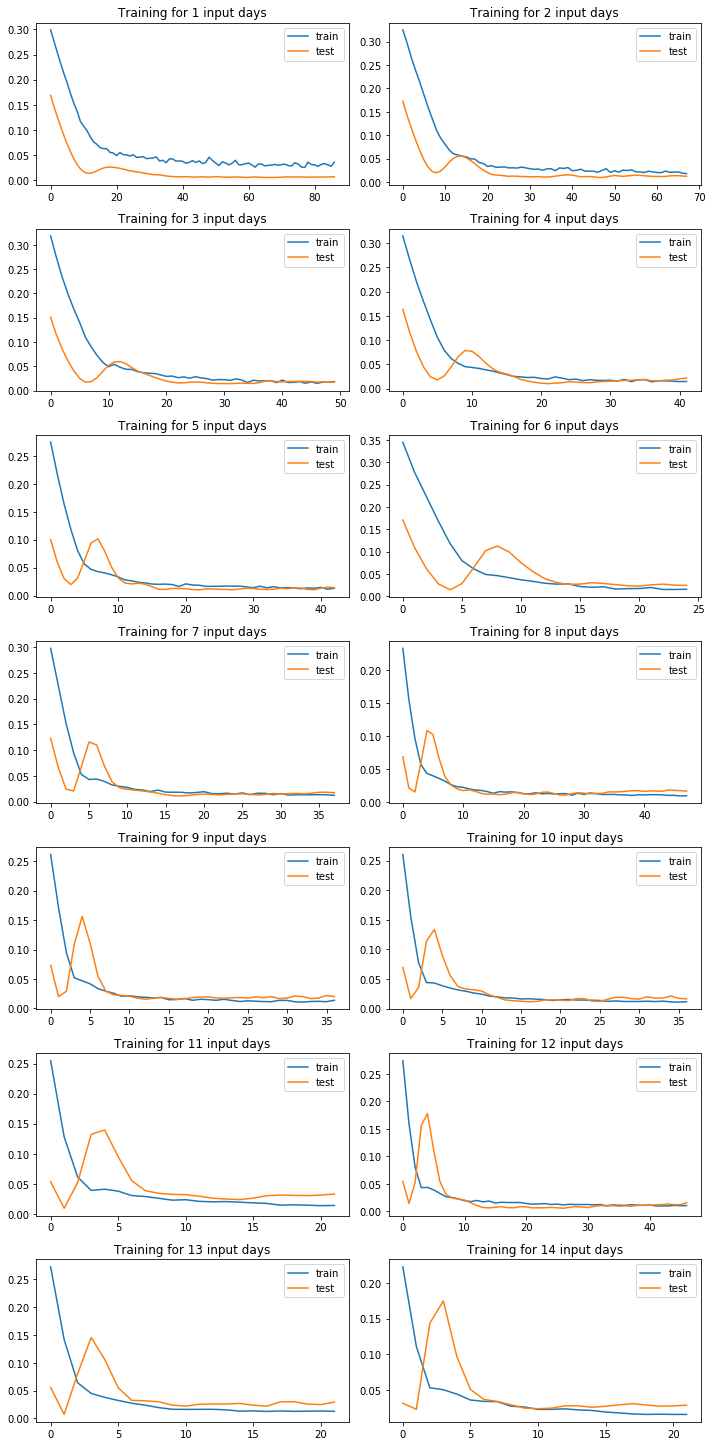

In [173]:
plots(histories)

In [155]:
cases_rmse = [x[0] for x in predictions]
deaths_rmse = [x[1] for x in predictions]

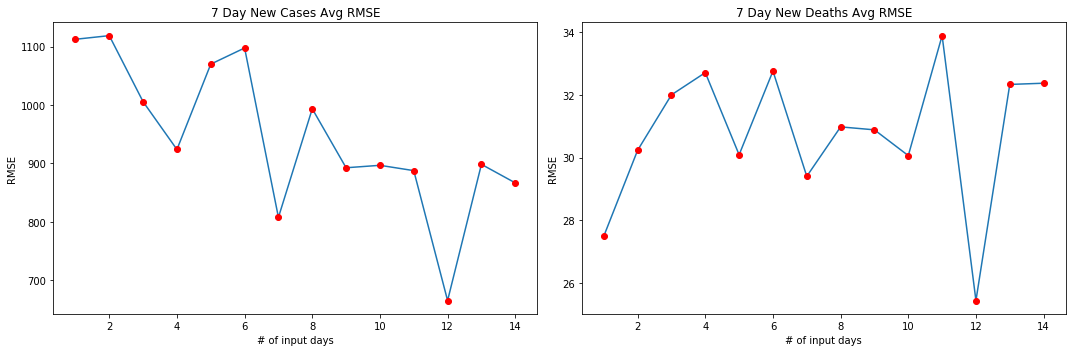

In [171]:
fig = plt.figure(figsize=(15,5))

for (i, rmse, title) in zip([1,2], [cases_rmse, deaths_rmse], ['7 Day New Cases Avg RMSE', '7 Day New Deaths Avg RMSE']):
    plt.subplot(1,2,i)
    plt.plot(range(1,len(predictions)+1),rmse)
    plt.plot(range(1,len(predictions)+1),rmse,'or')
    plt.title(title)
    plt.xlabel('# of input days')
    plt.ylabel('RMSE')
    
plt.tight_layout()
plt.show()